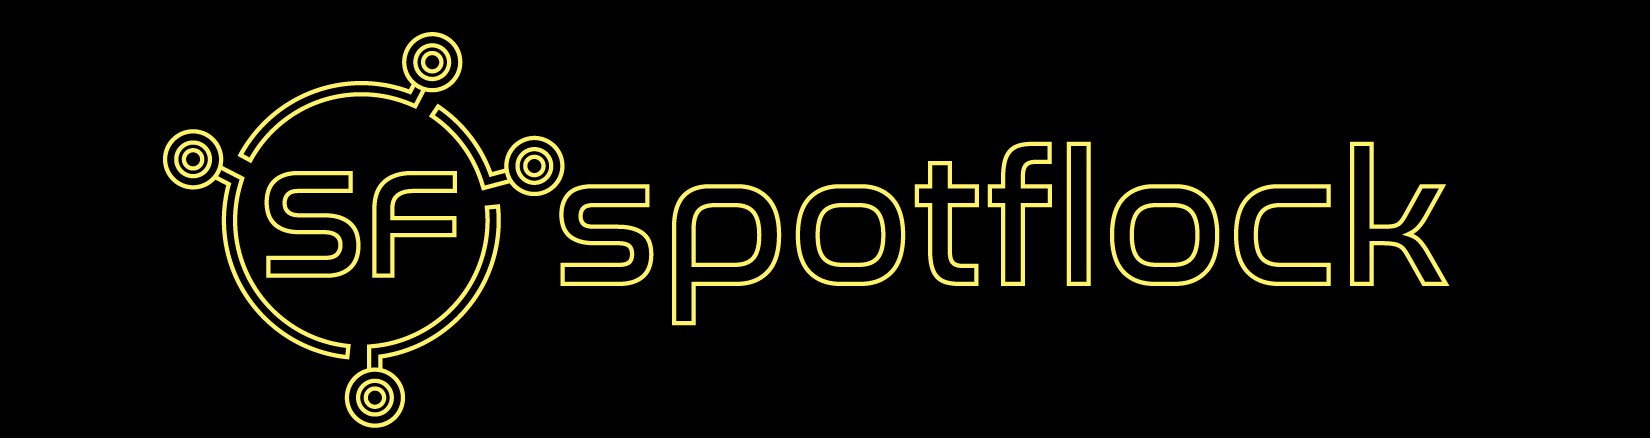

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
import csv

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import load_model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


from pathlib import Path
import os.path

from sklearn.metrics import classification_report, confusion_matrix
import itertools

# IMAGE CLASSIFIER FOR MONUMENTS

## Creating Dataset using bing-image-downloader

In [2]:
#pip install bing-image-downloader

In [3]:
mkdir /Users/Chopra/Documents/GL/images_for_spotflock

mkdir: /Users/Chopra/Documents/GL/images_for_spotflock: File exists


In [4]:
from bing_image_downloader import downloader

In [5]:
monuments = ['Gateway of India','Golden Temple','Hawa Mahal','Humayun Tomb','India Gate','Qutub Minar',
 'Red Fort', 'Sanchi Stupa', 'Statue of Unity', 'Taj Mahal']

In [7]:
#for i in range (len(monuments)):
    #downloader.download(monuments[i], limit=150,output_dir='/Users/Chopra/Documents/GL/images_for_spotflock/',
                   #adult_filter_off = False, )

## We have created a dataset of 10 monuments, each containing 150 images. 

# Load and Transform Data

In [8]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

# Placing data into a Dataframe


In [9]:
dataset = "Documents/GL/images_for_spotflock"
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [10]:
image_df

,Filepath,Label
0,Documents/GL/images_for_spotflock/Humayun Tomb...,Humayun Tomb
1,Documents/GL/images_for_spotflock/Humayun Tomb...,Humayun Tomb
2,Documents/GL/images_for_spotflock/Humayun Tomb...,Humayun Tomb
3,Documents/GL/images_for_spotflock/Humayun Tomb...,Humayun Tomb
4,Documents/GL/images_for_spotflock/Humayun Tomb...,Humayun Tomb
...,...,...
1430,Documents/GL/images_for_spotflock/Qutub Minar/...,Qutub Minar
1431,Documents/GL/images_for_spotflock/Qutub Minar/...,Qutub Minar
1432,Documents/GL/images_for_spotflock/Qutub Minar/...,Qutub Minar
1433,Documents/GL/images_for_spotflock/Red Fort/ima...,Red Fort


# Visualizing images from the dataset

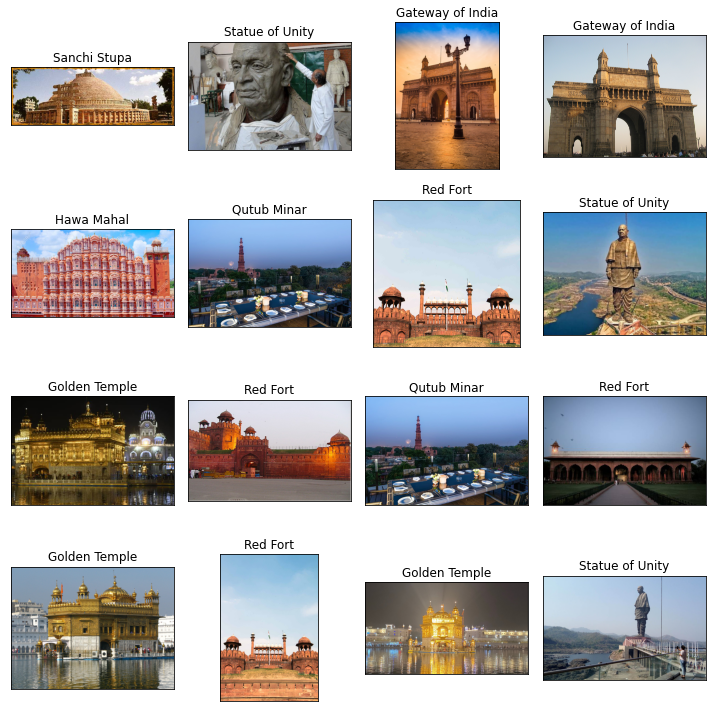

In [11]:
random_index = np.random.randint(0, len(image_df), 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Data Preprocessing

In [12]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [13]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,zoom_range=0.3,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [14]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 919 validated image filenames belonging to 10 classes.
Found 229 validated image filenames belonging to 10 classes.
Found 287 validated image filenames belonging to 10 classes.


## Resizing and Rescaling

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Training the model

I will be using MobileNetV2 for classification, with earlystopping. I will also be creating model checkpoints. 


**Batch size** : 32

**Epochs** : 100

**Input Shape** : (224, 224, 3)

**Output layer** : 10



# MODEL 1

In [16]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [17]:
# Create checkpoint callback
checkpoint_path = "indian_place_classifier"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

## Setting up EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 consecutive epochs


In [18]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# Training the model

In [19]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/20
29/29 [==============================] - 102s 3s/step - loss: 2.2225 - accuracy: 0.2089 - val_loss: 1.8687 - val_accuracy: 0.5546
Epoch 2/20
29/29 [==============================] - 87s 3s/step - loss: 1.7826 - accuracy: 0.4864 - val_loss: 1.4568 - val_accuracy: 0.7249
Epoch 3/20
29/29 [==============================] - 86s 3s/step - loss: 1.3640 - accuracy: 0.6464 - val_loss: 1.0777 - val_accuracy: 0.7948
Epoch 4/20
29/29 [==============================] - 86s 3s/step - loss: 1.0695 - accuracy: 0.7258 - val_loss: 0.7805 - val_accuracy: 0.8341
Epoch 5/20
29/29 [==============================] - 86s 3s/step - loss: 0.8668 - accuracy: 0.7693 - val_loss: 0.6467 - val_accuracy: 0.8646
Epoch 6/20
29/29 [==============================] - 86s 3s/step - loss: 0.7117 - accuracy: 0.8150 - val_loss: 0.5256 - val_accuracy: 0.8734
Epoch 7/20
29/29 [==============================] - 87s 3s/step - loss: 0.6204 - accuracy: 0.8313 - val_loss: 0.4583 - val_accuracy: 0.8952
Epoch 8/20
29/29 [=

# Model Evaluation


In [21]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.28929
Test Accuracy: 91.64%


# Visualizing loss curves

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('EPOCH')
  plt.ylabel('ERROR')
  plt.legend()
  plt.grid(True)

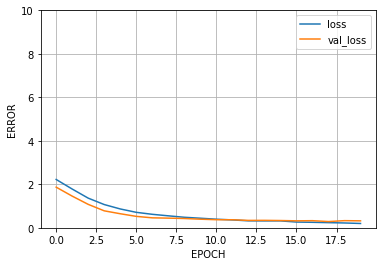

In [23]:
plot_loss(history)

# Making predictions on the Test Data

In [24]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapping the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Hawa Mahal', 'Gateway of India', 'Humayun Tomb', 'Qutub Minar', 'Red Fort']


In [25]:
train_images.class_indices

{'Gateway of India': 0,
 'Golden Temple': 1,
 'Hawa Mahal': 2,
 'Humayun Tomb': 3,
 'India Gate': 4,
 'Qutub Minar': 5,
 'Red Fort': 6,
 'Sanchi Stupa': 7,
 'Statue of Unity': 8,
 'Taj Mahal': 9}

## Displaying 15 random pictures from the dataset with their labels


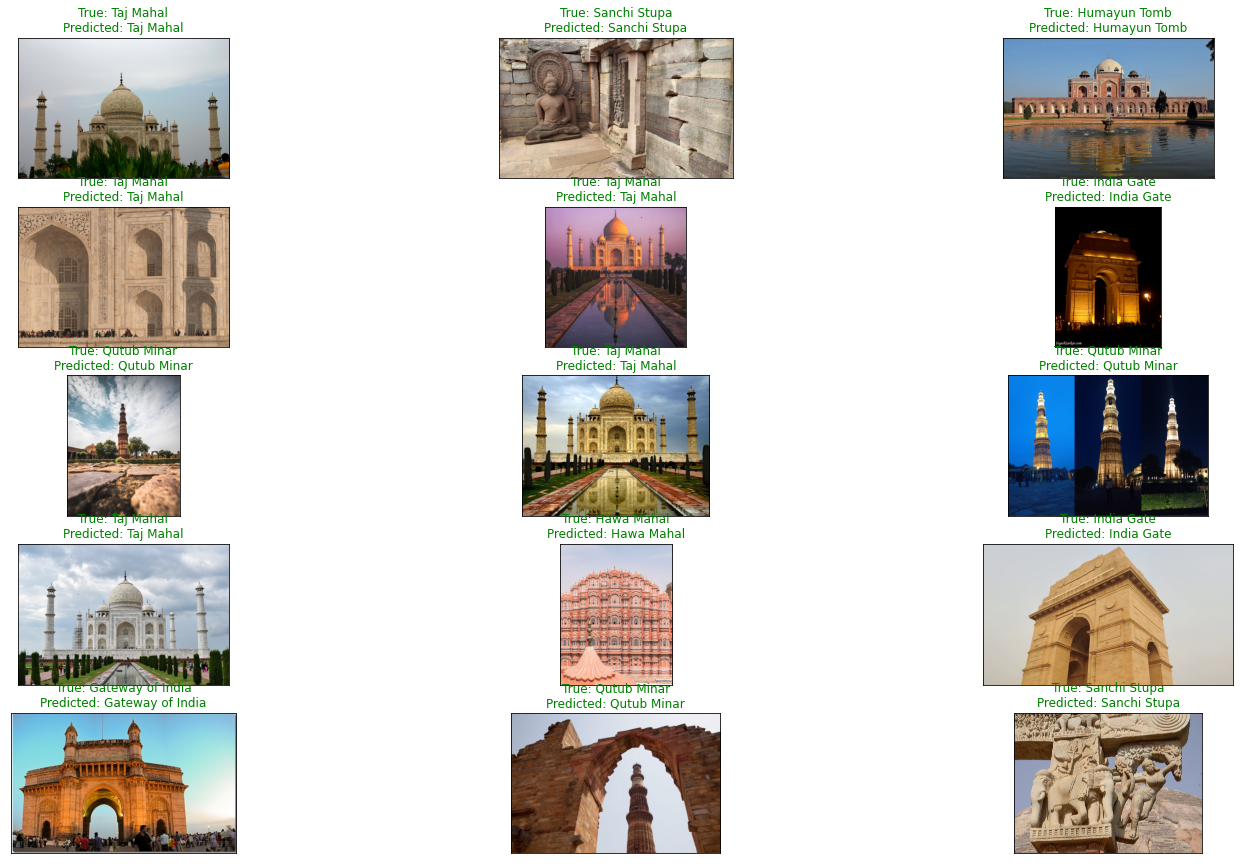

<Figure size 432x288 with 0 Axes>

In [26]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Plotting the Classification Reports and Confusion Matrix

In [27]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                  precision    recall  f1-score   support

Gateway of India       0.88      0.97      0.92        31
   Golden Temple       1.00      0.96      0.98        27
      Hawa Mahal       0.89      0.93      0.91        27
    Humayun Tomb       0.82      0.75      0.78        24
      India Gate       0.88      0.92      0.90        25
     Qutub Minar       1.00      0.86      0.92        35
        Red Fort       0.88      0.91      0.89        32
    Sanchi Stupa       0.93      0.90      0.91        29
 Statue of Unity       0.89      1.00      0.94        24
       Taj Mahal       0.97      0.97      0.97        33

        accuracy                           0.92       287
       macro avg       0.91      0.92      0.91       287
    weighted avg       0.92      0.92      0.92       287



In [28]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Gateway of India,0.882353,0.967742,0.923077,31.000000
Golden Temple,1.000000,0.962963,0.981132,27.000000
Hawa Mahal,0.892857,0.925926,0.909091,27.000000
Humayun Tomb,0.818182,0.750000,0.782609,24.000000
India Gate,0.884615,0.920000,0.901961,25.000000
Qutub Minar,1.000000,0.857143,0.923077,35.000000
Red Fort,0.878788,0.906250,0.892308,32.000000
Sanchi Stupa,0.928571,0.896552,0.912281,29.000000
Statue of Unity,0.888889,1.000000,0.941176,24.000000
Taj Mahal,0.969697,0.969697,0.969697,33.000000


## Save the Model in .h5 format

In [38]:
model.save('Spotflock_2.h5')

/Users/chopra/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Pickle the Model

In [39]:
import pickle


Best_model = history
file = 'Spotflock_2.pkl'
fileobj = open(file, 'wb')
pickle.dump(history, fileobj)
fileobj.close()

INFO:tensorflow:Assets written to: ram://4534d032-b00b-4ec6-8208-cd5c252768c0/assets


/Users/chopra/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/chopra/opt/anaconda3/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [40]:
pip freeze>requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Saving model in .Onnx format

### Installing tf2onnx, which converts Tensorflow models to Onnx

In [30]:
pip install tf2onnx

     |████████████████████████████████| 442 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 9.3 MB/s eta 0:00:01    |█▏                              | 440 kB 1.4 MB/s eta 0:00:09     |██████████████                  | 5.5 MB 10.5 MB/s eta 0:00:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
Note: you may need to restart the kernel to use updated packages.


In [35]:
import tf2onnx
import onnx

In [36]:
input_signature=[tf.TensorSpec((None, 224, 224, 3), name="input_name")],

onnx_model, _ = tf2onnx.convert.from_keras(model,input_signature)

onnx.save(onnx_model, 'Spotflock_onnx')